# Auswertung der Seattle AirBNB-Daten von 2016


AirBNB hat viele seiner Daten veröffentlicht. Die in dieser Auswertung untersuchten Daten stammen von 
https://www.kaggle.com/datasets/airbnb/seattle/data
und sind in der public domain unter CC0 verfügbar.

Die Auswertung kann angesehen werden: 
* [ohne Python-Code](index.html)
* [mit Python-Code](seattle_airbnb.html)


## Inhaltsverzeichnis


2. [Erste Übersicht](#erste-uebersicht)
3. [Beschreibung der DataFrames und ihrer Spalten](#beschreibung-der-dataframes-und-ihrer-spalten)
4. [Sind die Preise vom Stadtteil abhängig?](#sind-die-preise-vom-stadtteil-abhaengig)
5. [Gibt es eine Abhängigkeit der Preise von Feiertagen?](#gibt-es-eine-abhaengigkeit-der-preise-von-feiertagen)



In [31]:
# Bibliotheken importieren

import pandas as pd  # Importieren von Pandas für die Datenanalyse
import numpy as np  # Importieren von NumPy für numerische Operationen
import matplotlib.pyplot as plt  # Importieren von Matplotlib für die Datenvisualisierung
import holidays # Importieren von holidays für Feiertage
import seaborn as sns # Importieren von seaborn für die Datenvisualisierung
import geopandas as gpd # Importieren von geopandas für die Geodatenanalyse
import geodatasets as gd # Importieren von geodataset für die Geodatenanalyse


# Daten einlesen
calendar = pd.read_csv('./data/calendar.csv')
listings = pd.read_csv('./data/listings.csv')
reviews = pd.read_csv('./data/reviews.csv')

# Erste Übersicht

## Beschreibung der DataFrames und ihrer Spalten

### calendar DataFrame
| Spalte       | Beschreibung |
|--------------|--------------|
| listing_id   | Eindeutige ID des Listings |
| date         | Datum der Verfügbarkeit |
| available    | Verfügbarkeit des Listings an diesem Datum ('t' für verfügbar, 'f' für nicht verfügbar) |
| price        | Preis des Listings an diesem Datum |

### listings DataFrame
| Spalte                            | Beschreibung |
|-----------------------------------|--------------|
| id                                | Eindeutige ID des Listings |
| listing_url                       | URL des Listings auf Airbnb |
| scrape_id                         | ID des Scrape-Vorgangs |
| last_scraped                      | Datum des letzten Scrape-Vorgangs |
| name                              | Name des Listings |
| summary                           | Zusammenfassung des Listings |
| space                             | Beschreibung des Raums |
| description                       | Detaillierte Beschreibung des Listings |
| experiences_offered               | Angebotene Erfahrungen (z.B. none) |
| neighborhood_overview             | Überblick über die Nachbarschaft |
| notes                             | Zusätzliche Notizen zum Listing |
| transit                           | Informationen zu öffentlichen Verkehrsmitteln in der Nähe |
| thumbnail_url                     | URL des Vorschaubilds des Listings |
| medium_url                        | URL des mittleren Bilds des Listings |
| picture_url                       | URL des Bilds des Listings |
| xl_picture_url                    | URL des großen Bilds des Listings |
| host_id                           | Eindeutige ID des Hosts |
| host_url                          | URL des Host-Profils auf Airbnb |
| host_name                         | Name des Hosts |
| host_since                        | Datum, seit dem der Host auf Airbnb aktiv ist |
| host_location                     | Standort des Hosts |
| host_about                        | Beschreibung des Hosts |
| host_response_time                | Antwortzeit des Hosts |
| host_response_rate                | Antwortquote des Hosts |
| host_acceptance_rate              | Annahmequote des Hosts |
| host_is_superhost                 | Ob der Host ein Superhost ist ('t' für ja, 'f' für nein) |
| host_thumbnail_url                | URL des Vorschaubilds des Hosts |
| host_picture_url                  | URL des Bilds des Hosts |
| host_neighbourhood                | Nachbarschaft des Hosts |
| host_listings_count               | Anzahl der Listings des Hosts |
| host_total_listings_count         | Gesamtanzahl der Listings des Hosts |
| host_verifications                | Verifizierungen des Hosts |
| host_has_profile_pic              | Ob der Host ein Profilbild hat ('t' für ja, 'f' für nein) |
| host_identity_verified            | Ob die Identität des Hosts verifiziert ist ('t' für ja, 'f' für nein) |
| street                            | Straße des Listings |
| neighbourhood                     | Nachbarschaft des Listings |
| neighbourhood_cleansed            | Bereinigte Nachbarschaft des Listings |
| neighbourhood_group_cleansed      | Bereinigte Nachbarschaftsgruppe des Listings |
| city                              | Stadt des Listings |
| state                             | Bundesstaat des Listings |
| zipcode                           | Postleitzahl des Listings |
| market                            | Markt des Listings |
| smart_location                    | Intelligente Standortbeschreibung des Listings |
| country_code                      | Ländercode des Listings |
| country                           | Land des Listings |
| latitude                          | Breitengrad des Listings |
| longitude                         | Längengrad des Listings |
| is_location_exact                 | Ob der Standort genau ist ('t' für ja, 'f' für nein) |
| property_type                     | Art der Unterkunft |
| room_type                         | Art des Zimmers (z.B. Entire home/apt) |
| accommodates                      | Anzahl der Gäste, die das Listing beherbergen kann |
| bathrooms                         | Anzahl der Badezimmer |
| bedrooms                          | Anzahl der Schlafzimmer |
| beds                              | Anzahl der Betten |
| bed_type                          | Art der Betten |
| amenities                         | Annehmlichkeiten des Listings |
| square_feet                       | Quadratmeterzahl des Listings |
| price                             | Preis des Listings |
| weekly_price                      | Wochenpreis des Listings |
| monthly_price                     | Monatspreis des Listings |
| security_deposit                  | Kaution des Listings |
| cleaning_fee                      | Reinigungsgebühr des Listings |
| guests_included                   | Anzahl der im Preis inbegriffenen Gäste |
| extra_people                      | Preis für zusätzliche Gäste |
| minimum_nights                    | Mindestanzahl an Übernachtungen |
| maximum_nights                    | Höchstanzahl an Übernachtungen |
| calendar_updated                  | Datum der letzten Kalenderaktualisierung |
| has_availability                  | Ob das Listing Verfügbarkeit hat ('t' für ja, 'f' für nein) |
| availability_30                   | Verfügbarkeit in den nächsten 30 Tagen |
| availability_60                   | Verfügbarkeit in den nächsten 60 Tagen |
| availability_90                   | Verfügbarkeit in den nächsten 90 Tagen |
| availability_365                  | Verfügbarkeit in den nächsten 365 Tagen |
| calendar_last_scraped             | Datum des letzten Kalender-Scrape-Vorgangs |
| number_of_reviews                 | Anzahl der Bewertungen |
| first_review                      | Datum der ersten Bewertung |
| last_review                       | Datum der letzten Bewertung |
| review_scores_rating              | Bewertung des Listings |
| review_scores_accuracy            | Bewertung der Genauigkeit des Listings |
| review_scores_cleanliness         | Bewertung der Sauberkeit des Listings |
| review_scores_checkin             | Bewertung des Check-ins des Listings |
| review_scores_communication       | Bewertung der Kommunikation des Listings |
| review_scores_location            | Bewertung der Lage des Listings |
| review_scores_value               | Bewertung des Preis-Leistungs-Verhältnisses des Listings |
| requires_license                  | Ob eine Lizenz erforderlich ist ('t' für ja, 'f' für nein) |
| license                           | Lizenz des Listings |
| jurisdiction_names                | Zuständigkeitsnamen des Listings |
| instant_bookable                  | Ob das Listing sofort buchbar ist ('t' für ja, 'f' für nein) |
| cancellation_policy               | Stornierungsbedingungen des Listings |
| require_guest_profile_picture     | Ob ein Profilbild des Gastes erforderlich ist ('t' für ja, 'f' für nein) |
| require_guest_phone_verification  | Ob eine Telefonnummer des Gastes erforderlich ist ('t' für ja, 'f' für nein) |
| calculated_host_listings_count    | Berechnete Anzahl der Listings des Hosts |
| reviews_per_month                 | Anzahl der Bewertungen pro Monat |

### reviews DataFrame
| Spalte         | Beschreibung |
|----------------|--------------|
| listing_id     | Eindeutige ID des Listings |
| id             | Eindeutige ID der Bewertung |
| date           | Datum der Bewertung |
| reviewer_id    | Eindeutige ID des Bewerters |
| reviewer_name  | Name des Bewerters |
| comments       | Kommentare des Bewerters |

# Gibt es eine Abhängigkeit der Preise von Feiertagen?

Für diese Analyse müssen wir die Daten aus dem Calendar-Dataframe mit den Angaben zu den öffentlichen Feiertagen im US-Bundesstaat Washington (WA) kombinieren. Wir wollen die Preise an allen Tagen vor einem Feirtag oder Wochenendtag mit den übrigen Preisen vergleichen.

Werden Unterkünfte teurer, wenn man am nächsten Tag ausschlafen kann?

/tmp/ipykernel_2971/3263434742.py:32: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  calendar.fillna({'is_day_before_holiday':True}, inplace=True)


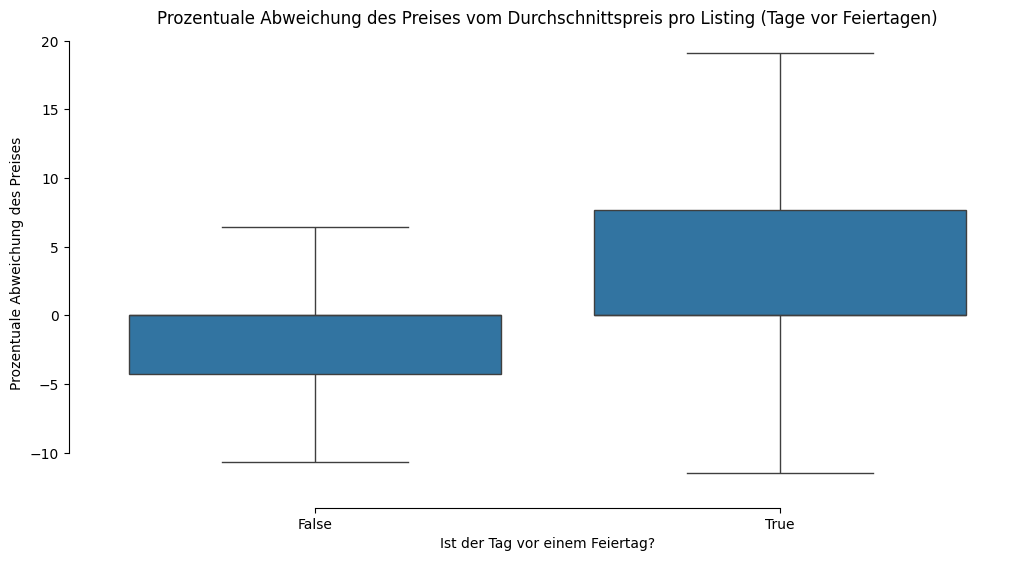

In [33]:




# aufbereiten der csv daten
calendar['_price'] = calendar['price'].replace('[\\$,]', '', regex=True).astype(float)
calendar['_date'] = pd.to_datetime(calendar['date'])
calendar['_available'] = calendar['available'].map({'t': True, 'f': False})

# Berechnen des Durchschnittspreises pro Listing (pandas ignoriert automatisch NaN-Werte)
average_price_per_listing = calendar.groupby('listing_id')['_price'].mean().reset_index()
average_price_per_listing.columns = ['listing_id', 'average_price']

# Zusammenführen der berechneten Durchschnittspreise mit dem ursprünglichen DataFrame
calendar = calendar.merge(average_price_per_listing, on='listing_id', how='left')

# Abweichung des Preises vom Durchschnittspreis pro listing berechnen
calendar['price_deviation'] = calendar['_price'] - calendar['average_price']

# prozentuale Abweichung des Preises vom Durchschnittspreis pro listing berechnen
calendar['price_deviation_percentage'] = calendar['price_deviation'] / calendar['average_price'] * 100

# Funktion zur Überprüfung, ob ein Datum ein Feiertag ist

us_holidays = holidays.US(state='WA')

def is_holiday(date):
    return date in us_holidays

# Spalte erstellen, die angibt, ob das Datum ein arbeitsfreier Tag ist
calendar['is_holiday_or_weekend'] = calendar['_date'].apply(lambda x: x.weekday() >= 5 or is_holiday(x))

# boolean Spalte erstellen, die angibt, ob das Datum direkt vor einem arbeitsfreien Tag liegt  
calendar['is_day_before_holiday'] = calendar['is_holiday_or_weekend'].shift(-1)
# NaN Werte in der letzten Zeile durch True ersetzen (1.1. ist ein Feiertag)
calendar.fillna({'is_day_before_holiday':True}, inplace=True)

# zwei candlestick-diagramme erstellen. prozentuale Abweichung des Preises vom Durchschnittspreis pro listing getrennt nach is_day_before_holiday.
plt.figure(figsize=(12, 6))
# außreißer ausblenden
sns.boxplot(x='is_day_before_holiday', y='price_deviation_percentage', data=calendar, showfliers=False)
sns.despine(offset=10, trim=True)
plt.title('Prozentuale Abweichung des Preises vom Durchschnittspreis pro Listing (Tage vor Feiertagen)')
plt.xlabel('Ist der Tag vor einem Feiertag?')
plt.ylabel('Prozentuale Abweichung des Preises')
plt.show()




# Sind die Preise vom Stadtteil abhängig?

Durch zusammenführen der Werte aus dem Calendar-Dataframe und dem Listings-Dataframe können wir den durchschnittlichen Preis pro Stadtteil (neighbourhood) ausrechnen.

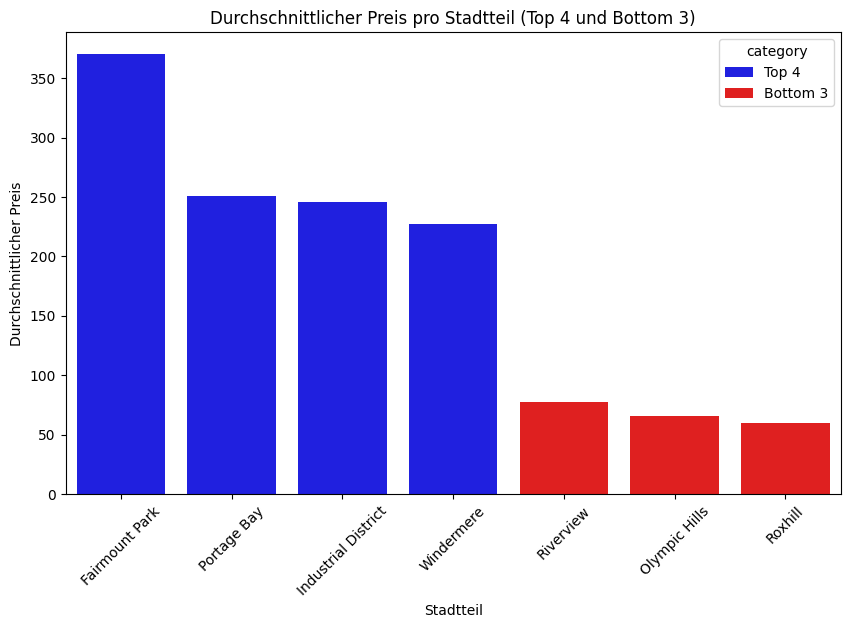

In [34]:
# Preis-Spalte im calendar DataFrame bereinigen und in float umwandeln
calendar['price'] = calendar['price'].replace('[\\$,]', '', regex=True).astype(float)

# Zusammenführen der DataFrames calendar und listings anhand der listing_id
merged_df = pd.merge(calendar, listings[['id', 'neighbourhood']], left_on='listing_id', right_on='id', how='left')

# Berechnen des durchschnittlichen Preises pro Stadtteil
average_price_per_neighbourhood = merged_df.groupby('neighbourhood')['price'].mean().reset_index()
average_price_per_neighbourhood.columns = ['neighbourhood', 'average_price']

# Sortieren der Stadtteile nach durchschnittlichem Preis
sorted_neighbourhoods = average_price_per_neighbourhood.sort_values(by='average_price', ascending=False)

# Auswählen der höchsten 4 und niedrigsten 3 Stadtteile
top_4_neighbourhoods = sorted_neighbourhoods.head(4)
bottom_3_neighbourhoods = sorted_neighbourhoods.tail(3)

# Zusammenführen der ausgewählten Stadtteile
selected_neighbourhoods = pd.concat([top_4_neighbourhoods, bottom_3_neighbourhoods])

# Balkendiagramm erstellen mit unterschiedlichen Farben für Top 4 und Bottom 3 Stadtteile
plt.figure(figsize=(10, 6))
colors = ['blue'] * 4 + ['red'] * 3
selected_neighbourhoods['category'] = ['Top 4'] * 4 + ['Bottom 3'] * 3
sns.barplot(x='neighbourhood', y='average_price', hue='category', data=selected_neighbourhoods, dodge=False, palette={'Top 4': 'blue', 'Bottom 3': 'red'})
plt.title('Durchschnittlicher Preis pro Stadtteil (Top 4 und Bottom 3)')
plt.xlabel('Stadtteil')
plt.ylabel('Durchschnittlicher Preis')
plt.xticks(rotation=45)
plt.show()


Die Preise in den verschiedenen Stadtteilen von Seattle unterscheiden sich deutlich. Mit Abstand am teuersten sind Unterkünfte in Fairmount Park.